/Users/phantom/Library/Application Support/Tellurium/telocal/python-3.6.0/lib/python3.6/site-packages/matplotlib-2.0.0-py3.6-macosx-10.10-x86_64.egg/matplotlib/__init__.py:1401: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


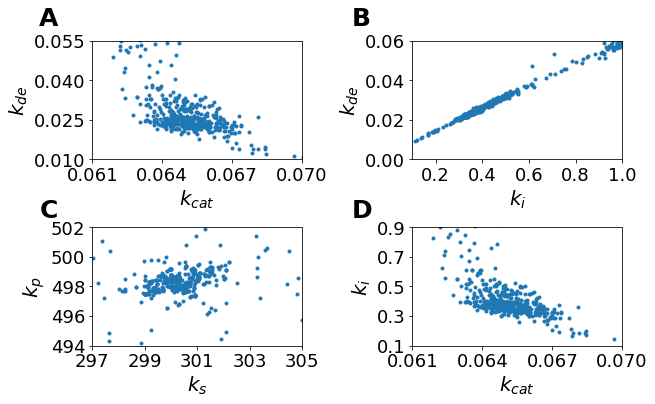

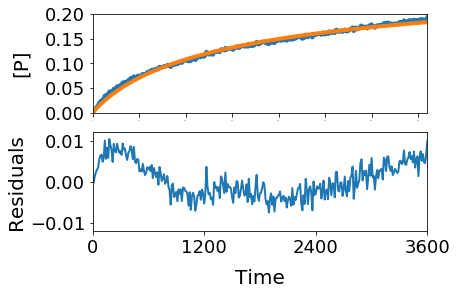

In [2]:
%matplotlib inline
"""
Monteo Carlo Bootstrap of a HIV proteinase model by Kuzmic.
Calculates CI of Nelder-Mead fitter through Monte Carlo Bootstrap algorithm.
Plots the correlation between parameters.
"""

import roadrunner as rr
import tellurium as te
import numpy as np
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
import random
import lmfit
import copy

np.random.seed(0)

model = """
M + M -> E; k_a*M*M - k_d*E;
E + S -> ES; k_on*E*S - k_s*ES;
ES -> E + P; k_r*ES;
P + E -> EP; k_on*P*E - k_p*EP;
I + E -> EI; k_on*I*E - k_i*EI;
EI -> EJ; k_de*EI;

I = 0.004; E = 0.004; S = 25;
M = 0; ES = 0; P = 0; EP = 0; EI = 0; EJ = 0;
k_on = 100; k_d = 0.001; k_a = 0.1;
k_s = 300; k_r = 10; k_p = 500; k_i = 0.1; k_de = 0.1;
"""

r = te.loada(model)
raw_data = np.genfromtxt("/Users/phantom/devel/src/tellurium-examples/Kuzmic.csv", delimiter=",")
raw_data = raw_data[1:,:]

# Objective function
def f(ps, raw):
    r.reset()
    r.k_s = ps['k_s'].value
    r.k_r = ps['k_r'].value
    r.k_p = ps['k_p'].value
    r.k_i = ps['k_i'].value
    r.k_de = ps['k_de'].value

    r.timeCourseSelections = ["time","P"]

    s = r.simulate(0, 3600, 301)

    return raw[:,1] - s[1:,1]

# Get initial residual and good initial parameters
fp = []

params = lmfit.Parameters()
params.add('k_s', value = 300., min=0, max=600)
params.add('k_r', value = 10, min=0, max=100)
params.add('k_p', value = 500., min=0, max=1000)
params.add('k_i', value = 0.1, min=0.,max=1)
params.add('k_de', value = 0.1, min=0, max=1)

while (len(fp) == 0):

    fitresult = lmfit.minimize(f, params, method='nelder', args=(raw_data,), tol=1e-10, options={'maxfev':20000,'ftol':1e-10,'xtol':1e-10})
    fp.append([fitresult.params.get('k_s'), fitresult.params.get('k_r'),
                  fitresult.params.get('k_p'), fitresult.params.get('k_i'),
                   fitresult.params.get('k_de')])

    residual = copy.deepcopy(fitresult.residual)

    redchirec = fitresult.redchi

# Initial fit
r.resetToOrigin()
r.k_s = fp[-1][0].value
r.k_r = fp[-1][1].value
r.k_p = fp[-1][2].value
r.k_i = fp[-1][3].value
r.k_de = fp[-1][4].value
r.timeCourseSelections = ["time","P"]

initresult = r.simulate(0, 3600, 301)[1:,:]

# Monte Carlo Bootstrap
samplingN = 500
sampleks = []
samplekr = []
samplekp = []
sampleki = []
samplekde = []

temp_initresult = copy.deepcopy(initresult)

for i in range(samplingN):
    for j in range(len(initresult)):
        temp_initresult[j][1] = initresult[j][1] + random.choice(residual)

    ret = lmfit.minimize(f, params, method='nelder', args=(temp_initresult,), tol=1e-10, options={'maxfev':20000,'ftol':1e-10,'xtol':1e-10})

    sampleks.append(ret.params.get('k_s').value)
    samplekr.append(ret.params.get('k_r').value)
    samplekp.append(ret.params.get('k_p').value)
    sampleki.append(ret.params.get('k_i').value)
    samplekde.append(ret.params.get('k_de').value)

# Calculate CI
CI = [1.96*np.std(sampleks)/(np.sqrt(samplingN)),
1.96*np.std(samplekr)/(np.sqrt(samplingN)),
1.96*np.std(samplekp)/(np.sqrt(samplingN)),
1.96*np.std(sampleki)/(np.sqrt(samplingN)),
1.96*np.std(samplekde)/(np.sqrt(samplingN))]


# Plotting - Parameter correlation
import string
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111)
ax.spines['top'].set_color('none')
ax.spines['bottom'].set_color('none')
ax.spines['left'].set_color('none')
ax.spines['right'].set_color('none')
ax.tick_params(labelcolor='w', top='off', bottom='off', left='off', right='off')
ax.tick_params(axis='x', pad=30)
ax.tick_params(axis='y', pad=30)

ax1 = fig.add_subplot(221)
ax1.set_ylabel("$k_{de}$", fontsize=20)
ax1.set_xlabel("$k_{cat}$", fontsize=20)
plt.plot(samplekr, samplekde, '.')
plt.axis([0.061, 0.07, 0.01, 0.055])
plt.yticks(fontsize = 18)
plt.xticks(fontsize = 18)
plt.xticks(np.arange(0.061, 0.071, 0.003))
plt.yticks(np.arange(0.01, 0.0551, 0.015))
ax1.text(-0.1, 1.05, string.ascii_uppercase[0], transform=ax.transAxes,
            size=25, weight='bold')

ax2 = fig.add_subplot(222)
ax2.set_ylabel("$k_{de}$", fontsize=20)
ax2.set_xlabel("$k_{i}$", fontsize=20)
plt.plot(sampleki, samplekde, '.')
plt.yticks(fontsize = 18)
plt.xticks(fontsize = 18)
plt.yticks(np.arange(0.0, 0.061, 0.02))
plt.xticks(np.arange(0., 1.1, 0.2))
plt.axis([0.1, 1.0, 0.0, 0.06])
ax2.text(0.49, 1.05, string.ascii_uppercase[1], transform=ax.transAxes,
            size=25, weight='bold')

ax3 = fig.add_subplot(223)
ax3.set_ylabel("$k_{p}$", fontsize=20)
ax3.set_xlabel("$k_{s}$", fontsize=20)
plt.plot(sampleks, samplekp, '.')
plt.yticks(fontsize = 18)
plt.xticks(fontsize = 18)
plt.yticks(np.arange(494, 502.1, 2.))
plt.xticks(np.arange(297, 305.1, 2.))
plt.axis([297, 305, 494, 502])
ax3.text(-0.1, 0.42, string.ascii_uppercase[2], transform=ax.transAxes,
            size=25, weight='bold')

ax4 = fig.add_subplot(224)
ax4.set_ylabel("$k_{i}$", fontsize=20)
ax4.set_xlabel("$k_{cat}$", fontsize=20)
plt.plot(samplekr, sampleki, '.')
plt.yticks(fontsize = 18)
plt.xticks(fontsize = 18)
plt.xticks(np.arange(0.061, 0.071, 0.003))
plt.yticks(np.arange(0.1, 0.91, 0.2))
plt.axis([0.061, 0.07, 0.1, 0.9])
ax4.text(0.49, 0.42, string.ascii_uppercase[3], transform=ax.transAxes,
            size=25, weight='bold')

plt.tight_layout(h_pad=1)
plt.show()

# Plotting - Fit and residual
fig = plt.figure()
ax = fig.add_subplot(111)
ax.tick_params(axis='x', pad=20)
ax.tick_params(axis='y', pad=10)
ax.spines['top'].set_color('none')
ax.spines['bottom'].set_color('none')
ax.spines['left'].set_color('none')
ax.spines['right'].set_color('none')
ax.set_xlabel("Time", fontsize=20)
ax.tick_params(labelcolor='w', top='off', bottom='off', left='off', right='off')

ax1 = fig.add_subplot(211)
ax1.set_ylabel("[P]", fontsize=20, labelpad=15)
plt.plot(raw_data[:,0], raw_data[:,1], lw = 4)
plt.plot(raw_data[:,0], initresult[:,1], lw = 4)
plt.axis([0, 3600, 0, 0.2])
plt.yticks(fontsize = 18)
plt.xticks(fontsize = 0)
plt.yticks(np.arange(0, 0.21, 0.05))

ax2 = fig.add_subplot(212)
ax2.set_ylabel("Residuals", fontsize=20)
plt.axis([0, 3600, -0.012, 0.012])
plt.plot(raw_data[:,0], residual, lw=2)
plt.yticks(fontsize = 18)
plt.xticks(fontsize = 18)
plt.xticks(np.arange(0, 3600.1, 1200))
plt.yticks(np.arange(-0.01, 0.0121, 0.01))
plt.show()
